In [1]:
import torch
import scanpy as sc

from sklearn.metrics import adjusted_rand_score
from sklearn.cluster import KMeans
import numpy as np
import os

from scvi.model import SCVI
from scripts import constants
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

from rich.console import Console
sns.set()

Global seed set to 0


In [2]:
adata = sc.read_h5ad(os.path.join(constants.DEFAULT_DATA_PATH, "haber_2017/preprocessed/adata_top_2000_genes.h5ad"))

target_adata = adata[adata.obs['condition'] != 'Control'].copy()
background_adata = adata[adata.obs['condition'] == 'Control'].copy()

SCVI.setup_anndata(
    target_adata, layer="count"
)

INFO     No batch_key inputted, assuming all cells are same batch                            
INFO     No label_key inputted, assuming all cells have same label                           
INFO     Using data from adata.layers["count"]                                               
INFO     Successfully registered anndata object containing 4481 cells, 2000 vars, 1 batches, 
         1 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              
INFO     Please do not further modify adata until model is trained.                          


In [3]:
seeds = constants.DEFAULT_SEEDS
contrastiveVI_models = [
    torch.load(os.path.join(constants.DEFAULT_RESULTS_PATH, f"haber_2017/contrastiveVI/{x}/model.chkpt")) for x in seeds]
scVI_models = [
    torch.load(os.path.join(constants.DEFAULT_RESULTS_PATH, f"haber_2017/scVI/{x}/model.chkpt")) for x in seeds]

During startup - Warning messages:
1: package ‘methods’ was built under R version 3.6.1 
2: package ‘datasets’ was built under R version 3.6.1 
3: package ‘utils’ was built under R version 3.6.1 
4: package ‘grDevices’ was built under R version 3.6.1 
5: package ‘graphics’ was built under R version 3.6.1 
6: package ‘stats’ was built under R version 3.6.1 


In [4]:
scVI_latent_representations = [
    model.get_latent_representation(
        adata=target_adata) for model in tqdm(scVI_models)]

contrastiveVI_salient_latent_representations = [
    model.get_latent_representation(
        adata=target_adata, representation_kind="salient") for model in tqdm(contrastiveVI_models)]

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 15.52it/s]


In [5]:
scVI_aris = [adjusted_rand_score(
    target_adata.obs['condition'],
    KMeans(n_clusters=2).fit(latent).labels_
) for latent in tqdm(scVI_latent_representations)]

contrastiveVI_aris = [adjusted_rand_score(
    target_adata.obs['condition'],
    KMeans(n_clusters=2).fit(salient_latent).labels_
) for salient_latent in tqdm(contrastiveVI_salient_latent_representations)]

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.69s/it]


In [6]:
from sklearn.decomposition import PCA

In [7]:
scVI_pca = PCA().fit_transform(scVI_latent_representations[1])
contrastiveVI_pca = PCA().fit_transform(contrastiveVI_salient_latent_representations[1])

In [8]:
target_labels = target_adata.obs['condition']

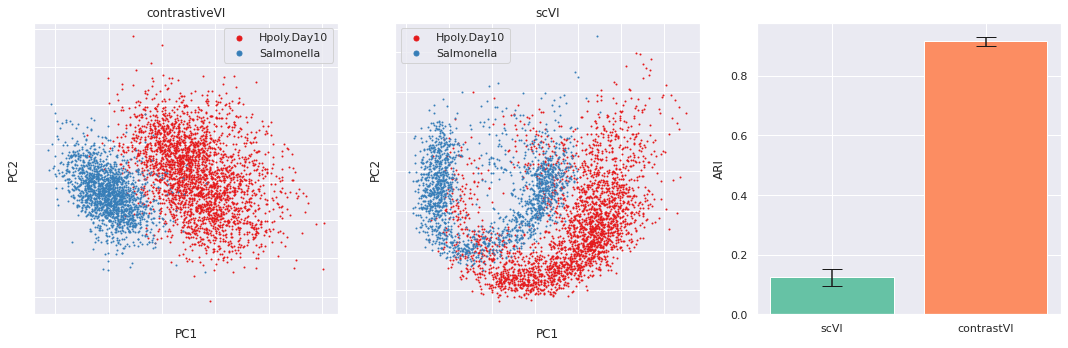

In [9]:
fig, (ax1, ax2, ax3) = plt.subplots(figsize=(15,5), nrows=1, ncols=3)

for i, label in enumerate(target_labels.unique()):
    ax1.scatter(
        contrastiveVI_pca[:, 0][target_labels == label],
        contrastiveVI_pca[:, 1][target_labels == label],
        s=1,
        label=label,
        color=sns.color_palette("Set1")[i]
    )

ax1.set_xlabel("PC1")
ax1.set_ylabel("PC2")
ax1.set_xticklabels([])
ax1.set_yticklabels([])
ax1.legend(markerscale=5)
ax1.set_title("contrastiveVI")

for i, label in enumerate(target_labels.unique()):
    ax2.scatter(
        scVI_pca[:, 0][target_labels == label],
        scVI_pca[:, 1][target_labels == label],
        s=1,
        label=label,
        color=sns.color_palette("Set1")[i]
    )

ax2.set_xlabel("PC1")
ax2.set_ylabel("PC2")
ax2.set_xticklabels([])
ax2.set_yticklabels([])
ax2.legend(markerscale=5)
ax2.set_title("scVI")

ax3.bar(
    ['scVI', 'contrastVI'],
    [np.mean(scVI_aris), np.mean(contrastiveVI_aris)],
    yerr=[np.std(scVI_aris), np.std(contrastiveVI_aris)],
    capsize=10,
    color=[sns.color_palette("Set2")[0], sns.color_palette("Set2")[1]])

ax3.set_ylabel("ARI")

plt.tight_layout()
plt.show()
    